In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

In [26]:
# Black-Scholes
def black_scholes(S, K, T, r, sigma, option_type='put'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price


# add options strategy
def add_options_strategy(portfolio, stock_symbol, option_type, strike_price, expiration_days, volatility):
    stock = portfolio[portfolio['Stock'] == stock_symbol]
    if stock.empty:
        print(f"stock {stock_symbol} not in current portfolio")
        return portfolio
    
    # Get current stock price using yfinance
    ticker = yf.Ticker(stock_symbol)
    current_price = ticker.history(period='1d')['Close'].iloc[-1]
    
    r = 0.02  
    T = expiration_days / 365
    
    option_price = black_scholes(current_price, strike_price, T, r, volatility, option_type)
    
    # add option to portfolio
    new_row = pd.DataFrame({
        'Symbol': [f"{stock_symbol}_{option_type.upper()}"],
        'Current Price': [current_price],
        'Volatility': [volatility],
        'Strike Price': [strike_price],
        'Expiration Days': [expiration_days],
        'Option Type': [option_type],
        'Type': ['Option'],
        'Price': [option_price],
        'Quantity': [100],  # assume 1 option contract (100 shares)
        'Strike': [strike_price],
        'Expiration': [expiration_days],
        'Underlying': [stock_symbol]
    })
    
    return new_row

In [ ]:
# read portfolio
portfolio = pd.read_csv('results/top10portfoliopick.csv')

# read options
options = pd.read_csv('Data/options_data.csv')


In [20]:
stock_symbols = portfolio['Stock'].tolist()

# get past one year monthly data
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=1)

df_volatility = pd.DataFrame(columns=['Symbol', 'Current Price', 'Volatility'])

for symbol in stock_symbols:
    historical_data = yf.download(symbol, start=start_date, end=end_date, interval='1mo')
    
    # use adjusted close price
    historical_prices = historical_data['Adj Close']
    
    # calculate current price
    current_price = historical_prices.iloc[-1]
    
    # calculate volatility (standard deviation)
    volatility = np.std(historical_prices.pct_change().dropna()) * np.sqrt(252)  # annualized volatility
    
    new_row = pd.DataFrame({
        'Symbol': [symbol],
        'Current Price': [current_price],
        'Volatility': [volatility]
    })
    df_volatility = pd.concat([df_volatility, new_row], ignore_index=True)

print(df_volatility)

[*********************100%***********************]  1 of 1 completed
/var/folders/n3/cwx8131570q5ljqcv1f22n6c0000gn/T/ipykernel_68450/2329749468.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_volatility = pd.concat([df_volatility, new_row], ignore_index=True)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complete

  Symbol  Current Price  Volatility
0   EBAY      58.110001    1.199977
1    ACN     345.670013    1.024330
2    CMG      58.590000    1.035525
3    FIS      89.099998    0.883413
4     HD     392.589996    0.927217
5    MAR     260.570007    0.693973
6    AMD     141.860001    1.530299
7    AXP     272.690002    0.601553
8     GM      50.959999    1.116703
9    AMT     211.259995    1.326325


In [21]:
# define strike price (10% above current price)
df_volatility['Strike Price'] = df_volatility['Current Price'] * 1.1

# define expiration time (30 days)
df_volatility['Expiration Days'] = 30

# define option type (assume we expect price to rise)
df_volatility['Option Type'] = 'put'


In [25]:
portfolio

,Stock,Monthly Return
0,EBAY,0.139541
1,ACN,0.095700
2,CMG,0.090364
3,FIS,0.081264
4,HD,0.076083
5,MAR,0.068969
6,AMD,0.068306
7,AXP,0.067618
8,GM,0.067295
9,AMT,0.065032


In [27]:
options_portfolio = pd.DataFrame()

# add_options_strategy(portfolio, stock_symbol, option_type, strike_price, expiration_days, volatility):
for _,row in df_volatility.iterrows():
    op = add_options_strategy(portfolio, row[0], row[5], row[3], row[4], row[2])
    options_portfolio = pd.concat([options_portfolio, op], ignore_index=True)

display(options_portfolio)


/var/folders/n3/cwx8131570q5ljqcv1f22n6c0000gn/T/ipykernel_68450/760069602.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  op = add_options_strategy(portfolio, row[0], row[5], row[3], row[4], row[2])
/var/folders/n3/cwx8131570q5ljqcv1f22n6c0000gn/T/ipykernel_68450/760069602.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  op = add_options_strategy(portfolio, row[0], row[5], row[3], row[4], row[2])
/var/folders/n3/cwx8131570q5ljqcv1f22n6c0000gn/T/ipykernel_68450/760069602.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

,Symbol,Current Price,Volatility,Strike Price,Expiration Days,Option Type,Type,Price,Quantity,Strike,Expiration,Underlying
0,EBAY_PUT,58.110001,1.199977,63.921001,30,put,Option,11.482224,100,63.921001,30,EBAY
1,ACN_PUT,345.670013,1.024330,380.237015,30,put,Option,61.422646,100,380.237015,30,ACN
2,CMG_PUT,58.590000,1.035525,64.449000,30,put,Option,10.484895,100,64.449000,30,CMG
3,FIS_PUT,89.099998,0.883413,98.009998,30,put,Option,14.426836,100,98.009998,30,FIS
4,HD_PUT,392.589996,0.927217,431.848996,30,put,Option,65.482085,100,431.848996,30,HD
5,MAR_PUT,260.570007,0.693973,286.627008,30,put,Option,36.802022,100,286.627008,30,MAR
6,AMD_PUT,141.860001,1.530299,156.046001,30,put,Option,33.382369,100,156.046001,30,AMD
7,AXP_PUT,272.690002,0.601553,299.959003,30,put,Option,35.866997,100,299.959003,30,AXP
8,GM_PUT,50.959999,1.116703,56.055999,30,put,Option,9.587345,100,56.055999,30,GM
9,AMT_PUT,211.259995,1.326325,232.385994,30,put,Option,44.787236,100,232.385994,30,AMT


In [30]:
filtered_options = pd.DataFrame()

for _, row in options_portfolio.iterrows():
    # Convert expiration days to date
    expiry_date = pd.Timestamp.today() + pd.Timedelta(days=row['Expiration'])
    expiry_date = expiry_date.strftime('%Y-%m-%d')
    
    # Convert strike prices to float for comparison and round up to nearest 10
    options_strike = pd.to_numeric(options['strike'], errors='coerce')
    portfolio_strike = float(np.ceil(float(row['Strike']) / 10) * 10)
    
    mask = (options['symbol'] == row['Underlying']) & \
           (abs(options_strike - portfolio_strike) < 0.01) & \
           (options['type'].str.lower() == row['Option Type'].lower()) & \
           (abs(pd.to_datetime(options['expiration']) - pd.to_datetime(expiry_date)) <= pd.Timedelta(days=7))
    
    matching_options = options[mask].copy()
    if not matching_options.empty:
        # Add portfolio information
        matching_options['portfolio_price'] = row['Price'] 
        matching_options['portfolio_quantity'] = row['Quantity']
        matching_options['portfolio_strike'] = portfolio_strike  # Use rounded strike price
        matching_options['portfolio_expiration_days'] = row['Expiration']
        matching_options['portfolio_volatility'] = row['Volatility']
        matching_options['portfolio_current_price'] = row['Current Price']
        
        filtered_options = pd.concat([filtered_options, matching_options], ignore_index=True)

display(filtered_options)

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,...,gamma,theta,vega,rho,portfolio_price,portfolio_quantity,portfolio_strike,portfolio_expiration_days,portfolio_volatility,portfolio_current_price
0,EBAY241129P00070000,EBAY,2024-11-29,70.0,put,0.00,7.10,6.60,50,7.60,...,0.04059,-0.05156,0.04887,-0.05721,11.482224,100,70.0,30,1.199977,58.110001
1,EBAY241206P00070000,EBAY,2024-12-06,70.0,put,0.00,7.28,5.30,50,9.25,...,0.04034,-0.05900,0.06075,-0.06613,11.482224,100,70.0,30,1.199977,58.110001
2,ACN241129P00390000,ACN,2024-11-29,390.0,put,0.00,28.85,27.50,21,30.20,...,0.00928,-0.08699,0.23685,-0.32852,61.422646,100,390.0,30,1.024330,345.670013
3,ACN241206P00390000,ACN,2024-12-06,390.0,put,0.00,29.25,27.50,21,31.00,...,0.00962,-0.12114,0.30498,-0.37991,61.422646,100,390.0,30,1.024330,345.670013
4,CMG241129P00070000,CMG,2024-11-29,70.0,put,0.00,9.85,8.70,107,11.00,...,0.00000,0.03365,0.00000,-0.06681,10.484895,100,70.0,30,1.035525,58.590000
5,CMG241206P00070000,CMG,2024-12-06,70.0,put,0.00,10.85,10.70,37,11.00,...,0.02766,-0.06209,0.04866,-0.07007,10.484895,100,70.0,30,1.035525,58.590000
6,FIS241129P00100000,FIS,2024-11-29,100.0,put,0.00,10.65,8.80,11,12.50,...,0.02732,-0.08427,0.07116,-0.08134,14.426836,100,100.0,30,0.883413,89.099998
7,FIS241206P00100000,FIS,2024-12-06,100.0,put,0.00,10.35,8.60,30,12.10,...,0.02734,-0.04337,0.07050,-0.09981,14.426836,100,100.0,30,0.883413,89.099998
8,HD241129P00440000,HD,2024-11-29,440.0,put,39.75,42.30,40.30,2,44.30,...,0.00680,-0.31086,0.31258,-0.35805,65.482085,100,440.0,30,0.927217,392.589996
9,HD241206P00440000,HD,2024-12-06,440.0,put,0.00,42.72,40.55,10,44.90,...,0.00682,-0.30046,0.37000,-0.41988,65.482085,100,440.0,30,0.927217,392.589996


Sell Put Options Strategy Analysis Results:
  Stock  Strike  Premium  Max_Loss  Max_Profit  Break_Even
0  EBAY    61.0     1.57      61.0        1.57       59.43
1   ACN   325.0     6.10     325.0        6.10      318.90
2   CMG    52.0     0.70      52.0        0.70       51.30
3   FIS    81.0     0.90      81.0        0.90       80.10
4    HD   357.5     0.26     357.5        0.26      357.24
5   MAR   230.0     8.50     230.0        8.50      221.50
6   AMD   167.5    13.60     167.5       13.60      153.90
7   AXP   240.0    16.15     240.0       16.15      223.85
8    GM    45.0     4.60      45.0        4.60       40.40
9   AMT   210.0    26.50     210.0       26.50      183.50


/var/folders/n3/cwx8131570q5ljqcv1f22n6c0000gn/T/ipykernel_68450/668341656.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


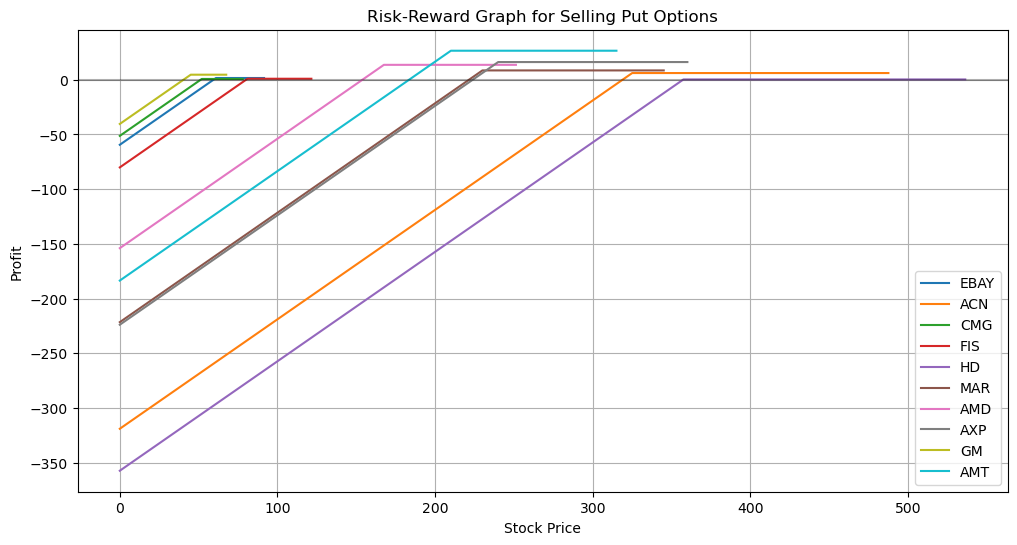

In [14]:
# select stocks from portfolio
stocks = portfolio['Stock'].tolist()

# create empty results DataFrame
results = pd.DataFrame(columns=['Stock', 'Strike', 'Premium', 'Max_Loss', 'Max_Profit', 'Break_Even'])

# analyze each stock
for stock in stocks:
    # filter put options for the stock
    stock_puts = options[(options['symbol'] == stock) & (options['type'] == 'put')]
    
    if len(stock_puts) > 0:
        # select the put option closest to the current price
        current_price = stock_puts['strike'].mean()  # use the average strike price as an estimate of the current price
        atm_put = stock_puts.iloc[(stock_puts['strike'] - current_price).abs().argsort()[:1]]
        
        # calculate strategy metrics
        strike = atm_put['strike'].values[0]
        premium = atm_put['ask'].values[0]
        max_loss = strike  # maximum loss is the strike price
        max_profit = premium  # maximum profit is the premium
        break_even = strike - premium  # break-even point
        
        # add to results
        new_row = pd.DataFrame({
            'Stock': [stock],
            'Strike': [strike], 
            'Premium': [premium],
            'Max_Loss': [max_loss],
            'Max_Profit': [max_profit],
            'Break_Even': [break_even]
        })
        results = pd.concat([results, new_row], ignore_index=True)

# display results
print("Sell Put Options Strategy Analysis Results:")
print(results)

# plot risk-reward graph
plt.figure(figsize=(12, 6))
for i, row in results.iterrows():
    stock_price = np.linspace(0, row['Strike'] * 1.5, 100)
    payoff = np.where(stock_price < row['Strike'], 
                      stock_price - row['Strike'], 
                      0) + row['Premium']
    plt.plot(stock_price, payoff, label=row['Stock'])

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Stock Price')
plt.ylabel('Profit')
plt.title('Risk-Reward Graph for Selling Put Options')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# calculate risk-reward ratio (maximum profit / maximum loss)
results['Risk_Reward_Ratio'] = results['Max_Profit'] / results['Max_Loss']

# calculate return rate (maximum profit / maximum loss) * 100
results['Return_Rate'] = (results['Max_Profit'] / results['Max_Loss']) * 100

# based on the following criteria:
# 1. high risk-reward ratio
# 2. reasonable return rate
# 3. maximum loss within acceptable range

# sort by risk-reward ratio
best_options = results.sort_values('Risk_Reward_Ratio', ascending=False)

print("\nOptions Sorted by Risk-Reward Ratio:")
print(best_options[['Stock', 'Strike', 'Premium', 'Risk_Reward_Ratio', 'Return_Rate']])



Options Sorted by Risk-Reward Ratio:
  Stock  Strike  Premium  Risk_Reward_Ratio  Return_Rate
9   AMT   210.0    26.50           0.126190    12.619048
8    GM    45.0     4.60           0.102222    10.222222
6   AMD   167.5    13.60           0.081194     8.119403
7   AXP   240.0    16.15           0.067292     6.729167
5   MAR   230.0     8.50           0.036957     3.695652
0  EBAY    61.0     1.57           0.025738     2.573770
1   ACN   325.0     6.10           0.018769     1.876923
2   CMG    52.0     0.70           0.013462     1.346154
3   FIS    81.0     0.90           0.011111     1.111111
4    HD   357.5     0.26           0.000727     0.072727


In [13]:
# recommend top 3 options
print("\nRecommended Top 3 Options:")
recommended = best_options.head(3)
for _, option in recommended.iterrows():
    print(f"\nStock: {option['Stock']}")
    print(f"Strike: ${option['Strike']:.2f}")
    print(f"Premium: ${option['Premium']:.2f}")
    print(f"Risk_Reward_Ratio: {option['Risk_Reward_Ratio']:.3f}")
    print(f"Return_Rate: {option['Return_Rate']:.1f}%")


Recommended Top 3 Options:

Stock: AMT
Strike: $210.00
Premium: $26.50
Risk_Reward_Ratio: 0.126
Return_Rate: 12.6%

Stock: GM
Strike: $45.00
Premium: $4.60
Risk_Reward_Ratio: 0.102
Return_Rate: 10.2%

Stock: AMD
Strike: $167.50
Premium: $13.60
Risk_Reward_Ratio: 0.081
Return_Rate: 8.1%


,Stock,Strike,Premium,Max_Loss,Max_Profit,Break_Even,Risk_Reward_Ratio,Return_Rate
9,AMT,210.0,26.50,210.0,26.50,183.50,0.126190,12.619048
8,GM,45.0,4.60,45.0,4.60,40.40,0.102222,10.222222
6,AMD,167.5,13.60,167.5,13.60,153.90,0.081194,8.119403
7,AXP,240.0,16.15,240.0,16.15,223.85,0.067292,6.729167
5,MAR,230.0,8.50,230.0,8.50,221.50,0.036957,3.695652
0,EBAY,61.0,1.57,61.0,1.57,59.43,0.025738,2.573770
1,ACN,325.0,6.10,325.0,6.10,318.90,0.018769,1.876923
2,CMG,52.0,0.70,52.0,0.70,51.30,0.013462,1.346154
3,FIS,81.0,0.90,81.0,0.90,80.10,0.011111,1.111111
4,HD,357.5,0.26,357.5,0.26,357.24,0.000727,0.072727
